# Multiclass classification - MNIST

## Import dataset

A flagship example of the classification issue is the recognition of digits based on the MNIST collection consisting of handwritten examples. This collection is so popular that it is available in most repositories of different packages - we will use, for example, the Scikit-Learn library data sets

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

Let's see what the input structure looks like

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


We have 70000 examples. Each of them has 784 attributes (i.e. 784 coordinates corresponding to the brightness of individual image pixels). We can see how such an exemplary element looks

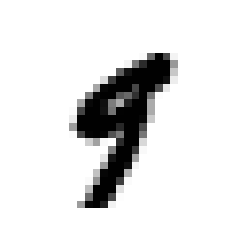

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation='nearest')
plt.axis('off')
plt.show()

Visually, it looks like a nine - let's get on with it. 

In [4]:
y[36000]

'9'

Handwriting is characterized by a great variety - this is well shown by a random sample from the MNIST collection containing several representatives of a given class (i.e. several digits)

In [5]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")    

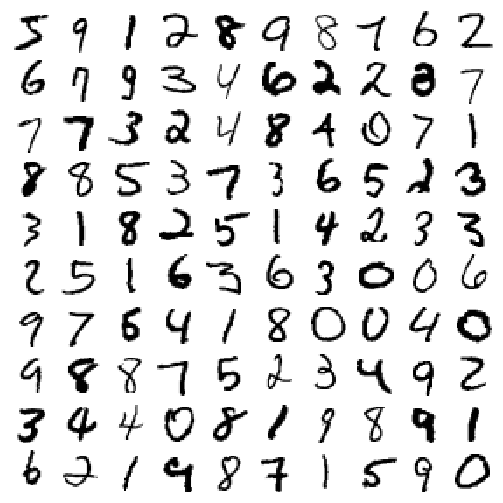

In [6]:
import numpy as np

plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

## Data preparation

First, let's break down the data set into a training and test part. Due to the homogeneity of the features, we can apply a random sampling without any fear (omitting more advanced sampling methods such as stratified sampling)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

To increase the learning efficiency of most algorithms, it is good to shuffle the test set

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 'Five' classifier

The issue under consideration is a multi-class classification, i.e. it is possible to choose several classes (exactly ten - each corresponding to one digit).  Let's first reduce the problem to binary classification - we want to recognize if an arbitrary number (for example a five) is shown in a given picture. The output of the classifier in such a situation is a logical value saying whether the presented example represents the number five or not

In [9]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

At the beginning we will choose a very simple linear classifier, whose learning algorithm is based on the stochastic gradient method

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Let's see if it can distinguish the number nine (example element) from the learned class representing the fives

In [11]:
sgd_clf.predict([some_digit])

array([False])

An exemplary representative of the learned class passes the membership test

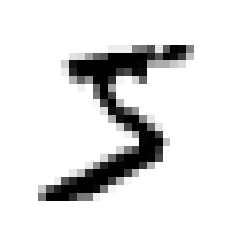

In [12]:
five_digit = X[0]
five_digit_image = five_digit.reshape(28,28)

plt.imshow(five_digit_image, cmap=matplotlib.cm.binary,
          interpolation='nearest')
plt.axis('off')
plt.show()

In [13]:
sgd_clf.predict([five_digit])

array([False])

Okay, we already know that the algorithm promises to work. So let's check out the more global statistics of classifier quality assessment. For this purpose, we can use the cross-validation test, which is able to show potential problems with the overfitting. As a performance metric, let's use accuracy

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9521 , 0.9623 , 0.96375])

We get great results with very little effort - this is quite rare. Since the results for all three tests do not differ significantly from each other, we do not suspect the model of bias. However, let's note a characteristic feature of the classifier under consideration - it has two classes - fives and non-fives, of which the number of representatives of the latter is significantly higher (having the same number of examples of each digit we have 10% of fridays and 90% of non-fives).

In view of the above, it is concluded that a classifier which would assign a logical value to any digit of false (i.e. a non-five) would have an accuracy of close to 90 %. This can be seen by writing a simple class representing such a dummy classifier

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9078, 0.912 , 0.9083])

In this light, our predictions are not so good. Therefore, we need to find more suitable metrics for a trained classifier - most of them are based on a comparison of predictions with expected values

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

The quality of the binary classifiers can be gathered by a confusion matrix. It consists of two rows and two columns. The first line corresponds to the negative examples (non-fives) and the second to the positive ones. The situation is similar for the columns except that it corresponds to the perspective of the classifier (the first column is the negative examples).

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predict)

array([[53627,   935],
       [ 1502,  3936]], dtype=int64)

In this case, we have:
1. 53505 correctly classified non-fives
2. 4084 correctly classified fives
3. 1075 Non-fives which are incorrectly classified as fives (these are the so-called first type errors)
4. 1341 Fives that have been incorrectly classified as non-fridays


On this basis we can determine certain measures of accuracy:
1. Precision as the number of correctly classified positive examples in relation to all positive examples (relative to the classifier)
2. Recall as a number of correctly classified positive examples in relation to all positive examples (relative to the facts)

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_predict))
print(recall_score(y_train_5, y_train_predict))

0.8080476288236502
0.7237955130562707


The metric that combines the two previous ones is F1 Score (harmonic mean of precision and recall)

In [19]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_predict))

0.7636046173246677


Note that F1 Score has a high value only if none of its components are close to zero. Additionally, it prefers situations where precision and recall are at a similar level, which does not always have to be a project priority.

Therefore, it is good to work out a procedure that allows to achieve a proper balance between precision and recall - for this purpose, for linear classifiers, we can modify the threshold on the basis of which the decision is made about the example belonging to a class

In [20]:
y_scores = sgd_clf.decision_function([five_digit])
y_scores

array([-46.80208116])

Let's set an example of such a threshold

In [21]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [22]:
threshold = 700
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

Depending on its value, the sample can be classified as positive or negative

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([ -1001.66316711,  -5133.34594209, -28653.74580381, ...,
        -2690.95923633, -16100.9124942 , -10873.98356392])

Let's see how the threshold value affects both precision and recall

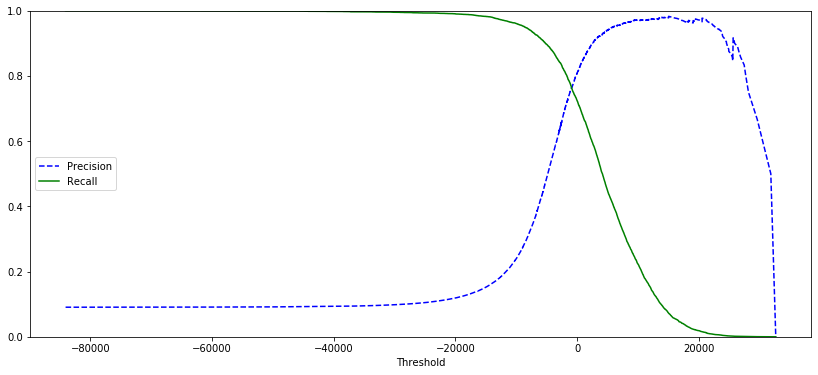

In [24]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(14,6))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()

From such a chart, it is easy to read the threshold value of interest for the given set accuracy or recall values. The threshold is a parameter here - if you give up on it, you get a precision-recall curve

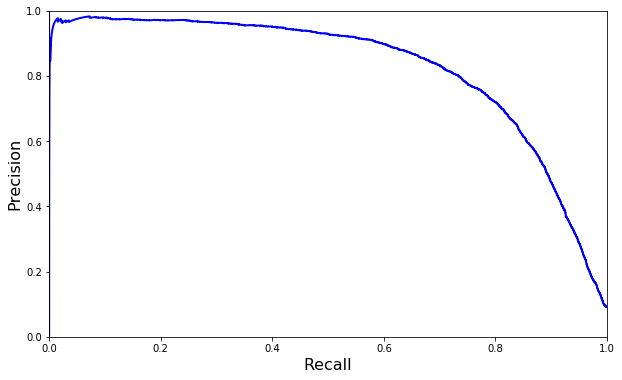

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(10,6))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precision, recall)

Another characteristic is the ROC curve (reveiver operating characteristic)

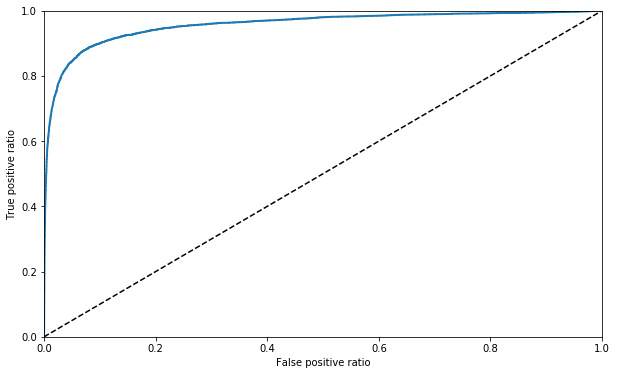

In [26]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False positive ratio')
    plt.ylabel('True positive ratio')

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

Precision-recall and ROC curves look similar - the former is more suitable when the positive class is rare (i.e. in the case under consideration) and the latter is used in other cases.

The numerical characteristic corresponding to the ROC curve is the AUC (area under the curve) - values close to unity mean high quality of the classifier

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9566414177033947

### Random Forest Classifier

With the right metrics, let's try to train a decision multi-tree model - Random Forest Model

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

For the purpose of visualizing these curves we need numerical results representing the decision-making function

<Figure size 576x432 with 0 Axes>

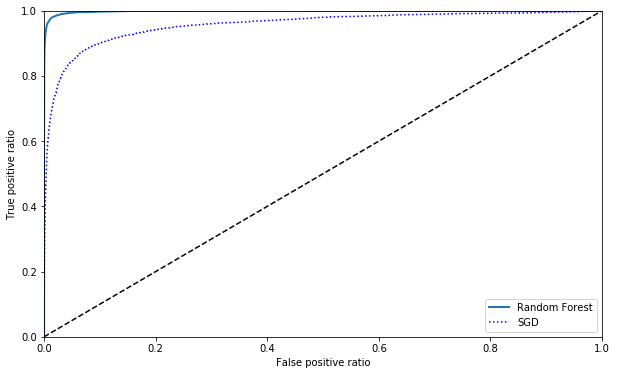

In [29]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.legend(loc='lower right')
plt.show()

The curve representing the new model lies closer to the upper left corner - so it has a larger area under the curve and therefore has better predictions.

So let's check the performance of this model

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983767416221615

## Multiclass classification

A multi-class classifier can be viewed as a set of binary classifiers - each corresponds to a single class and issues numerical predictions representing the value of which represents the strength of the model's belief that the example belongs to that class. The final verdict is given to the classifier whose predictions have the highest value - this strategy is called one-versus-all (OvA)

In [31]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) #9 - Wrong prediction!

array(['3'], dtype='<U1')

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-40124.31232571, -16524.20039441, -14663.17328856,
          -470.532333  ,  -3670.41691565,  -4175.06790903,
        -32827.02373099, -12559.62918633,  -5165.44871179,
         -7548.39722793]])

Note that the Scikit-Learn classifiers detect multiple classification issues and set OvA strategy by default.

Another approach may be to train as many classifiers as different pairs of classes - each of them is responsible for predicting which class is more likely. The target class is selected as the one that has won the most such 'duels'. This strategy is called one-versus-one (OvO)

In [33]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit]) #Correct prediction!

array(['4'], dtype=object)

Note that with this strategy, the number of classifiers increases squarely with the number of classes, so it is suitable for small and medium sets with a moderate number of classes (it is the default for support vector machines).

As before, you can try to train a model of a random forest

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit]) 

array(['9'], dtype=object)

In this case, it is more efficient to apply the OvA strategy (numerical results represent probabilities of belonging to a specific class)

In [35]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.  , 0.09, 0.  , 0.  , 0.01, 0.  , 0.89]])

In this particular case, the model is confident that the number nine is presented to him (85 % chance).

Let's go back to the linear classifier for a moment

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88435, 0.87045, 0.8795 ])

A standard way to improve the effectiveness of some learning algorithms is to feature scaling

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

C:\Users\adam\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\adam\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90285, 0.90305, 0.9079 ])

Such an inexpensive procedure allowed the performance to be significantly improved.

## Error analysis

In the case of multi-class classification, there is also a concept of confusion matrix - its structure is analogous to that of binary classification

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\adam\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\adam\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5610,    0,   20,    7,    9,   45,   37,    8,  191,    2],
       [   2, 6408,   39,   19,    2,   41,    7,    9,  172,   11],
       [  27,   26, 5344,   85,   77,   23,   61,   43,  320,   14],
       [  25,   19,  127, 5284,    2,  216,   22,   41,  328,   74],
       [  11,   13,   50,    8, 5294,   10,   36,   23,  266,  163],
       [  30,   16,   26,  160,   61, 4557,   78,   21,  419,   70],
       [  28,   19,   47,    1,   39,   99, 5497,    5,  122,    0],
       [  21,    9,   67,   26,   50,   12,    2, 5729,  130,  228],
       [  21,   61,   45,   93,    5,  127,   28,   10, 5372,   45],
       [  27,   21,   30,   61,  132,   36,    0,  180,  285, 5181]],
      dtype=int64)

Graphical representation highlights fields with a large number of elements

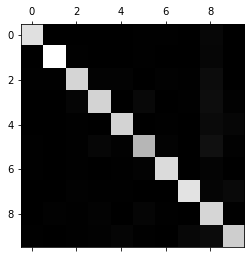

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Bright areas along the diagonal line suggest that most examples have been correctly classified.

To find out more about misclassified cases we can use this graphic representation by skipping diagonal elements. Additionally, we will standardize the result - then we will find out about the relative error 

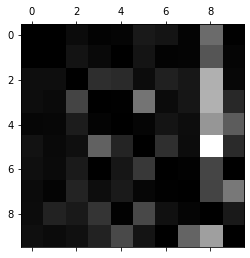

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The bright band corresponding to the digit 8 indicates that the classifier is wrongly classifying many examples as an eight. On the other hand, you can see some brighter fields in the row corresponding to digit 9, so many nines are wrongly classified as another digit.

So let's check how well classified the eights and nines and the ones that were misclassified look

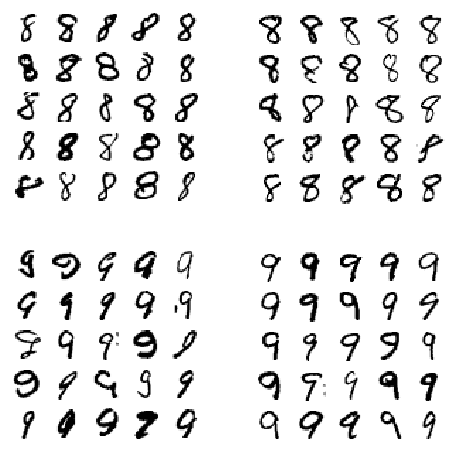

In [41]:
cl_a, cl_b = '8', '9'
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

The visualization shows that eights misclassified as nines are characterized by a small bottom loop, which can be seen by the classifier as the absence of such a loop. 

Nines classified as eights have a curved and rounded leg, which is perceived by the classifier as a bottom loop. In addition, in the same figure, it should be noted that in the penultimate row and the penultimate column, a digit even for human perception would undoubtedly be classified as an eighth.

The same situation applies to threes and fives

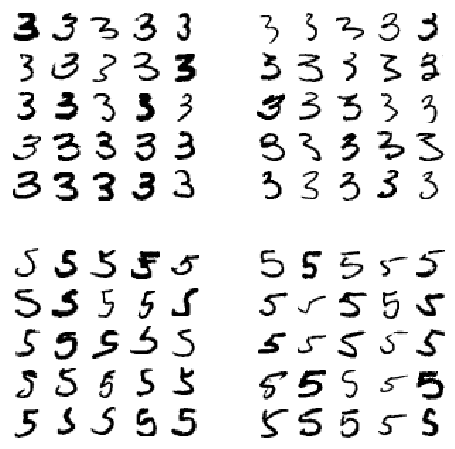

In [42]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

In addition, let's pay attention to the fives that have been classified as eights, with the most errors

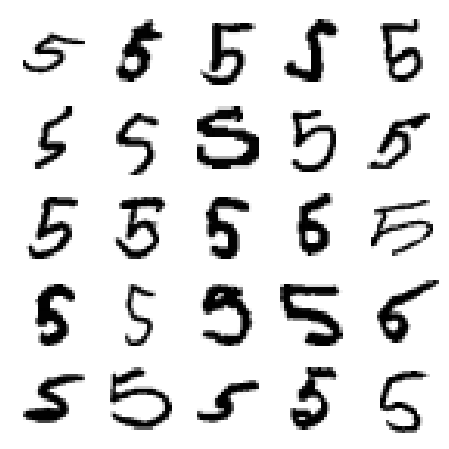

In [53]:
cl_a, cl_b = '5', '8'
X = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plot_digits(X[:25], images_per_row=5)

Similar considerations may be made in this case.

The above remarks suggest that in order to increase the accuracy of the classifier, a larger amount of data should be obtained or existing data should be transformed accordingly (for example by rotation and translation)

## Precision improving

We will now try to improve the accuracy of the classifier by tuning the hyperparameters via `GridSearchCV`.

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 210.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

It turns out that the best results for the algorithm k-nearest neighbours are obtained with `k=4` and the weight function based on distances

In [54]:
print("Grid search best parameters: ", grid_search.best_params_)
print("Grid search best scores: ", grid_search.best_score_)

Grid search best parameters:  {'n_neighbors': 4, 'weights': 'distance'}
Grid search best scores:  0.9733666666666666


This set of hyperparameters provides an accuracy of more than 97 % (on the test set)

In [55]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_pred, y_test)

0.9731

## Data augmentation

An accuracy of 97% is impressive. Further improvement proves to be a relatively difficult task. You can try with other models (for example, artificial neural networks). In order to improve the current model, we will use the technique of artificial extension of the training set.

Images are invariable in relation to translation (i.e. shifts). Therefore, we can change the position of the MNIST collection digits in relation to the geometric center of the image without changing the corresponding label.

In [58]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dx, dy], cval=0, mode='constant')
    return shifted_image.reshape([-1])

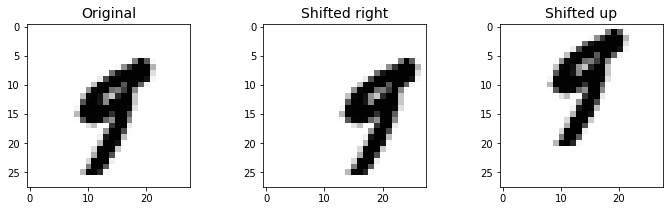

In [62]:
shifted_right_some_digit = shift_image(some_digit, 0, 5)
shifted_up_some_digit = shift_image(some_digit, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title('Original', fontsize=14)
plt.imshow(some_digit.reshape((28,28)), interpolation='nearest', cmap='Greys')
plt.subplot(132)
plt.title('Shifted right', fontsize=14)
plt.imshow(shifted_down_some_digit.reshape((28,28)), interpolation='nearest', cmap='Greys')
plt.subplot(133)
plt.title('Shifted up', fontsize=14)
plt.imshow(shifted_left_some_digit.reshape((28,28)), interpolation='nearest', cmap='Greys')

Following the same procedure for each element of the learning set (without modification of the test set) we extend it 

In [76]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx,dy in ((1,0),(-1,0),(0,1),(0,-1)):
    for image,label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

shuffle_index = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_index]
y_train_augmented = y_train_augmented[shuffle_index]

We can now choose the best of the tested classifiers and try to improve its performance by learning on the extended training set

In [77]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [78]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9809

We have a 98% accuracy classifier, which means that date augmentation has allowed for a noticeable improvement.